## Project details

` The goal of this project is to predict if a client will subscribe to a term deposit or not. The dataset used was the Bank Marketing Data Set which was obtained from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/bank+marketing). This is a classification problem, and because the dataset is highly imbalanced, various tecniques such as class reweighing,undersampling and oversampling were used to address this imbalance issue.`


## Dataset description

`The Bank Marketing Dataset available on the UCI Machine Learning Repository is a collection of data related to telemarketing campaigns for a Portuguese banking institution. The dataset contains information about customer demographics, previous contact history, economic indicators, and the outcome of the marketing campaign (whether the customer subscribed to a term deposit or not).`

`Source: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001`

  


#### Import necessary libraries

In [1]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import  accuracy_score
from sklearn.metrics import make_scorer,precision_score,recall_score
from sklearn.metrics import roc_auc_score,precision_recall_fscore_support
from sklearn.metrics import classification_report,confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline


#### Import data

In [2]:
#download the dataset
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#unzip data
!unzip -q '/content/bank-additional.zip'

In [3]:
#read data
data=pd.read_csv('/content/bank-additional/bank-additional-full.csv',sep=';')

#### EDA

In [4]:
#check shape
data.shape

(41188, 21)

`The dataset has 41188 rows and 21 columns (which includes our target variable)`

In [5]:
#data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
#rename y column as subscription
data.rename(columns={'y':'subscription'},inplace=True)

In [7]:
#check first 5 rows
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscription
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
#check nulls
data.isna().sum().sum()

0

In [9]:
#check duplicates
data.duplicated().sum()

12

In [10]:
#drop duplicates
data.drop_duplicates(inplace=True)

`There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values will be treated as a possible class label`


#### Subscription

no     88.733728
yes    11.266272
Name: subscription, dtype: float64




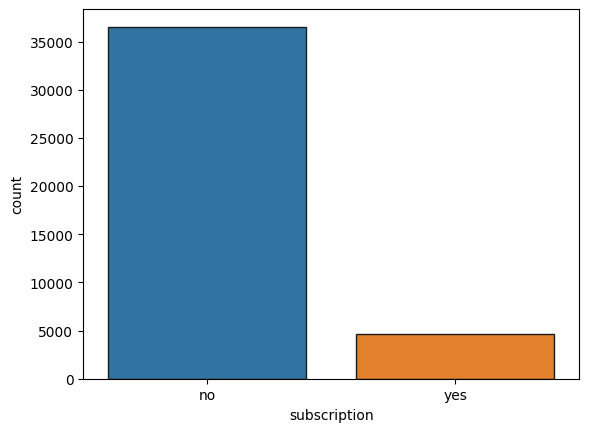

In [11]:
print(data.subscription.value_counts(normalize=True)*100)
print('\n')
sns.countplot(x=data.subscription,edgecolor='0.1')
plt.show()

`There are less people who subcribed to term deposit compared to non subscribers.The ratio is about 89:11 (non subscribers: subscribers), hence, our data is also imbalanced` 

#### Age

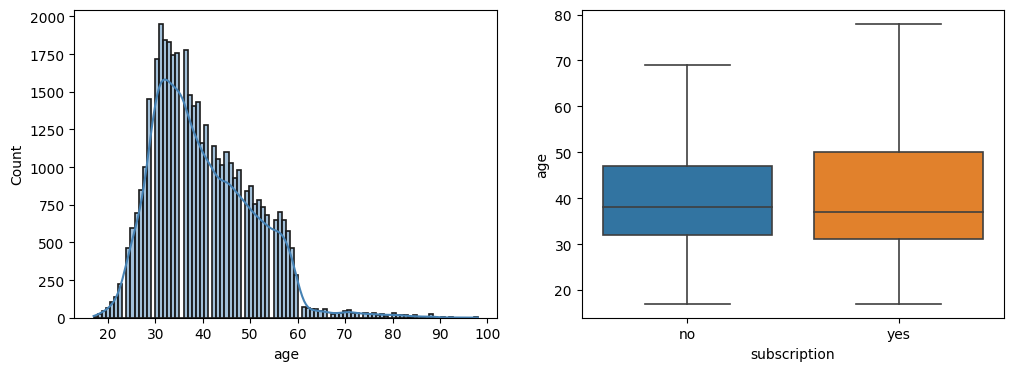

In [12]:
#age graph
fig,ax=plt.subplots(1,2,figsize=(12,4))
sns.histplot(data=data.age,kde=True,ax=ax[0],color='steelblue',edgecolor='0.1',linewidth=1.2)
sns.boxplot(data=data,y='age',x='subscription',ax=ax[1],linewidth=1.2,sym='')
plt.show()

`From the graphs above, it can be seen that the mean age is around 38, with lowest age been around 17 and maximum age around 100. there are more people represented in ages of 30-40 than the rest. The age of clients doesnt influence subscription alone as the median age is almost the same for both subscribers and non-subscribers` 

#### Job

What job has more subscribers?




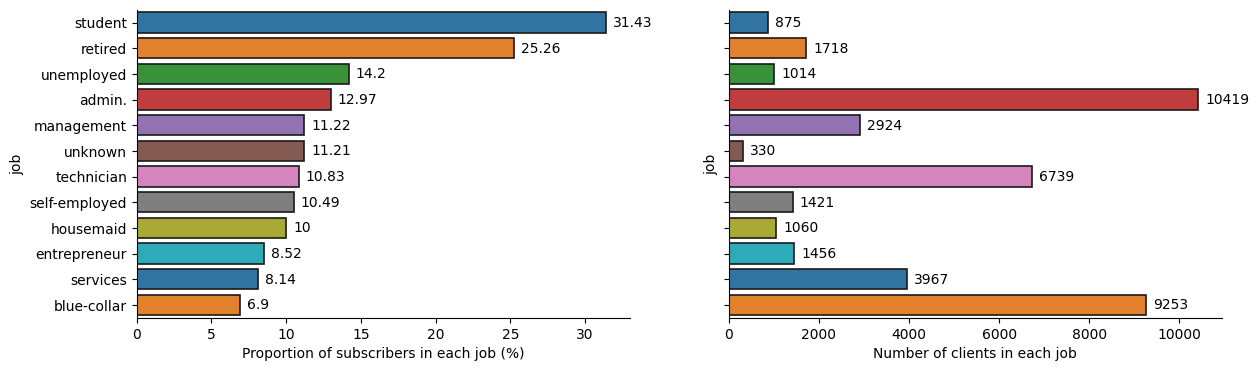

In [13]:
#get proportion of clients who subscribed in each job group
job_sub_propn=(data.groupby('job')['subscription'].value_counts(normalize=True)*100).\
                                            unstack(level='job').loc['yes'].round(2)
job_sub_propn=job_sub_propn.sort_values(ascending=False)

#plot
fig,axes=plt.subplots(1,2,figsize=(14,4),sharey=True)
ax=sns.barplot(y=job_sub_propn.index,x=job_sub_propn,palette='tab10',
                edgecolor='0.1',linewidth=1.2,ax=axes[0])

ax1=sns.countplot(y=data.job,ax=axes[1],order=job_sub_propn.index,palette='tab10',
                   edgecolor='0.1',linewidth=1.2)
#display bar values by bar
ax.bar_label(ax.containers[0], padding=5)
ax1.bar_label(ax1.containers[0], padding=5)
sns.despine()
ax.set(xlabel='Proportion of subscribers in each job (%)')
ax1.set(xlabel='Number of clients in each job')
plt.show()

`it can be seen that clients who identify as student subscribed more than other groups(31% of students subscribed) even though the number of students are realtively small compared to other groups. Clients with blue-collar jobs have the least amount of subscribers with just about 6.9% of the total 9253 subscribing` 

#### Marital

which marital group subscribed the most?


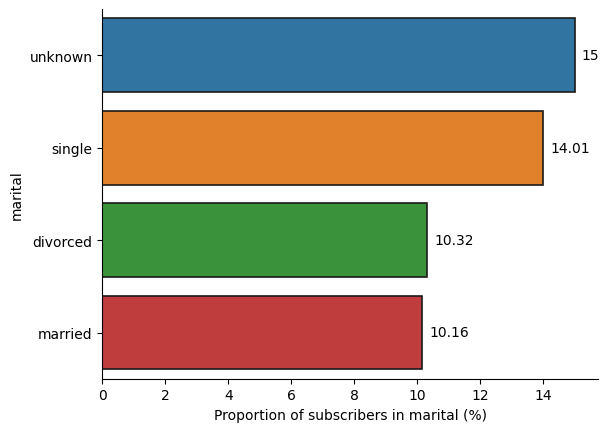

In [14]:
#get proportion of clients who subscribed in each marital group
marital_sub_propn=(data.groupby('marital')['subscription'].value_counts(normalize=True)*100).\
                                            unstack(level='marital').loc['yes'].round(2)
marital_sub_propn=marital_sub_propn.sort_values(ascending=False)

#plot
ax=sns.barplot(y=marital_sub_propn.index,x=marital_sub_propn,
                palette='tab10',edgecolor='0.1',linewidth=1.2,)
#display bar values by bar
ax.bar_label(ax.containers[0],padding=5)
sns.despine()
ax.set(xlabel='Proportion of subscribers in marital (%)')
plt.show()

`clients who identify as single have the highest proportion of subscribers.`

#### Education

In [15]:
print('Existing education values:', data.education.unique())
#group all basic level education together
data['education']=data['education'].replace({'basic.4y':'basic' ,'basic.6y':'basic', 'basic.9y':'basic'})
#validate change
print('new education values :', data.education.unique())

Existing education values: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
new education values : ['basic' 'high.school' 'professional.course' 'unknown' 'university.degree'
 'illiterate']


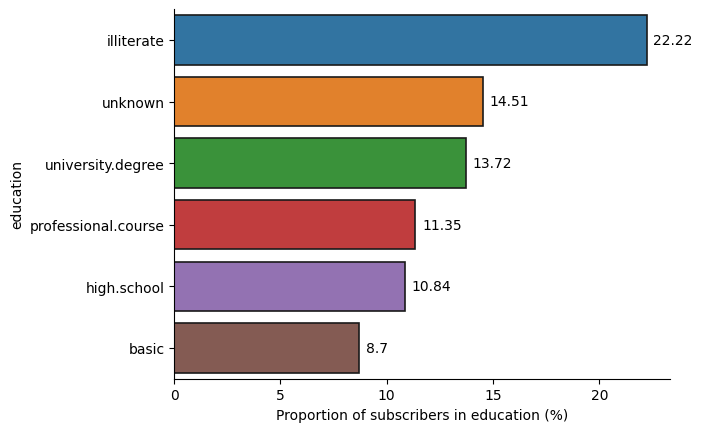

In [16]:
#get proportion of clients who subscribed in each education group
edu_sub_propn=(data.groupby('education')['subscription'].value_counts(normalize=True)*100).\
                                            unstack(level='education').loc['yes'].round(2)
edu_sub_propn=edu_sub_propn.sort_values(ascending=False)

#plot
ax=sns.barplot(y=edu_sub_propn.index,x=edu_sub_propn,
                palette='tab10',edgecolor='0.1',linewidth=1.2,)
#display bar values by bar
ax.bar_label(ax.containers[0],padding=5)
sns.despine()
ax.set(xlabel='Proportion of subscribers in education (%)')
plt.show()

`clients who are illterate subscribed more than all other groups. clients with basic education have the least subscription rate of all the group` 

#### Default, housing,	loan

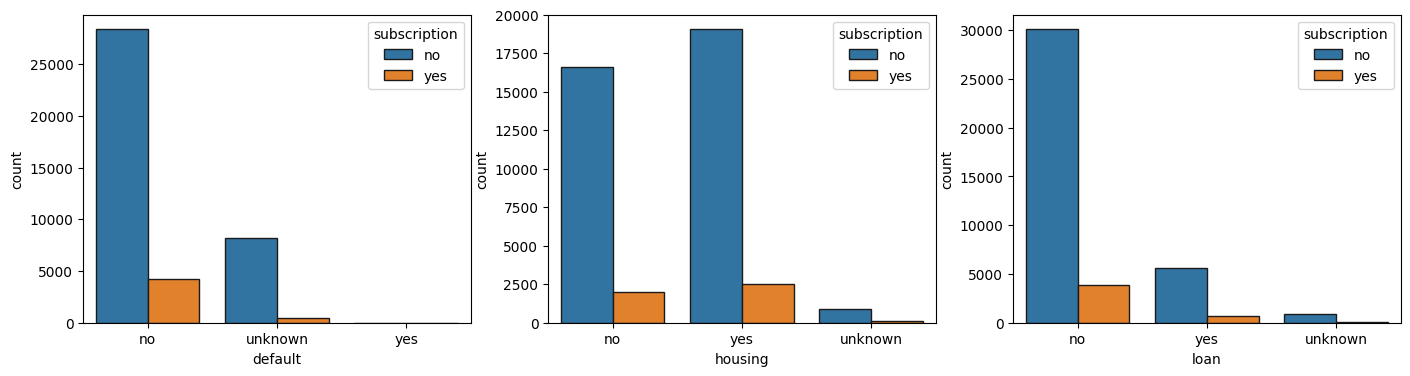

In [17]:
fig,ax=plt.subplots(1,3,figsize=(17,4))
sns.countplot(data=data,x='default',hue='subscription',ax=ax[0],edgecolor='0.1')
sns.countplot(data=data,x='housing',hue='subscription',ax=ax[1],edgecolor='0.1')
sns.countplot(data=data,x='loan',hue='subscription',ax=ax[2],edgecolor='0.1')
plt.show()

`Clients who have housing loan subscribed just a little more than those without housing loan as opposed to the case of those with personal loan, where those without personal loans have high subscription more than those with personal loans. `

do clients with housing loans also have personal loans?

In [18]:
data.groupby('housing')['loan'].value_counts().unstack().loc[('no','yes'),('no','yes')]

loan,no,yes
housing,,
no,16058.0,2557.0
yes,17880.0,3691.0


`3691 clients with housing loan,also have personal loan`

#### Month and day of the week

Which months and day of the week had higher number of subscription?

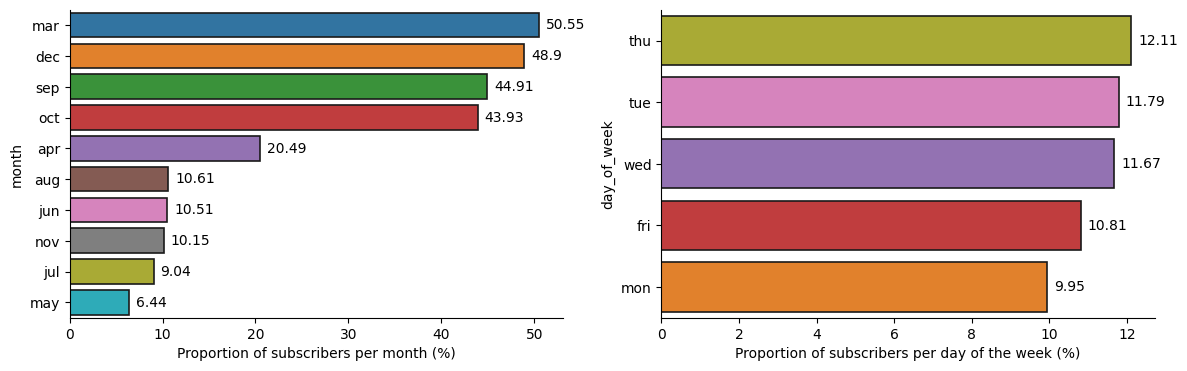

In [19]:
#get proportion of clients who subscribed in each month group
month_sub_propn=(data.groupby('month')['subscription'].value_counts(normalize=True)*100).\
                                            unstack(level='month').loc['yes'].round(2)
month_sub_propn=month_sub_propn.sort_values(ascending=False)
#get proportion of clients who subscribed in each day of the week group
dow_sub_propn=(data.groupby('day_of_week')['subscription'].value_counts(normalize=True)*100).\
                                            unstack(level='day_of_week').loc['yes'].round(2)
dow_sub_propn=dow_sub_propn.sort_values(ascending=False)

#plot
fig,axes=plt.subplots(1,2,figsize=(14,4))
ax=sns.barplot(y=month_sub_propn.index,x=month_sub_propn,palette='tab10',
                edgecolor='0.1',linewidth=1.2,ax=axes[0])

ax1=sns.barplot(y=dow_sub_propn.index,x=dow_sub_propn,palette='tab10_r',
                edgecolor='0.1',linewidth=1.2,ax=axes[1])
#display bar values by bar
ax.bar_label(ax.containers[0],padding=5)
ax1.bar_label(ax1.containers[0],padding=5)
sns.despine()
ax.set(xlabel='Proportion of subscribers per month (%)')
ax1.set(xlabel='Proportion of subscribers per day of the week (%)')
plt.show()

`From the plot above, it can be observed that the month of march,december,september and october had higher subscription. while the day of week with higher subscription is thursday. other factors may contribute to this subscription rate.`

#### Does last contact duration matter?

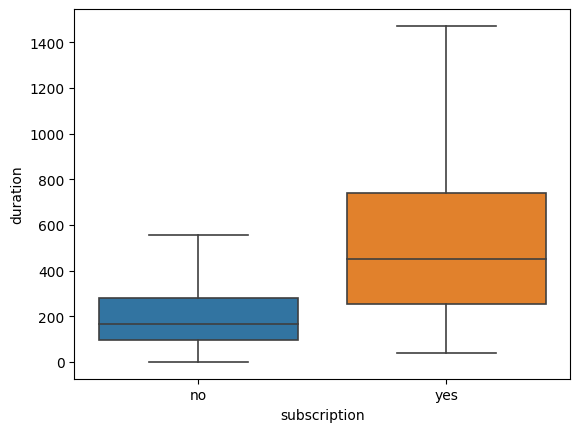

In [20]:
sns.boxplot(data=data,y='duration',x='subscription', linewidth=1.2,sym='')
plt.show()

`for client who subscribed,the median contact duration is around 500seconds, while the median contact duration for non subscribers is less than 200 seconds. the maximum time duration spent with non subscribers was around 600s as opposed to around 1500s spent with subcribers.` 

#### Previous marketing campaign effect

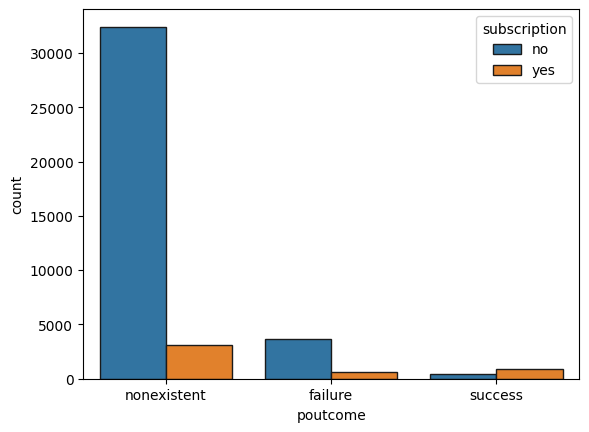

In [21]:
sns.countplot(x=data['poutcome'],hue=data['subscription'],edgecolor='0.1')
plt.show()

`clients with whom there was no previous campaign with, had higher subscription than others`

#### Social and economic context attributes

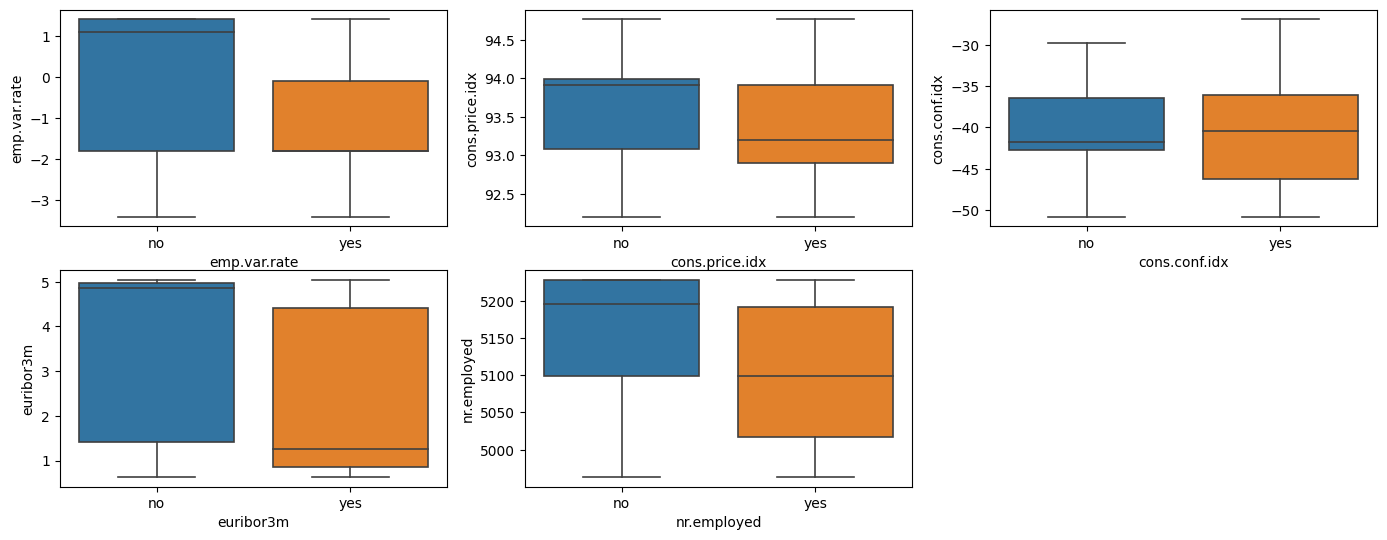

In [22]:
#social and economic attributes and subscription
sc_cols=['emp.var.rate',    'cons.price.idx',   'cons.conf.idx', 'euribor3m',   'nr.employed']
plt.figure(figsize=(17,40), facecolor='white')
plotnumber =1
for col in sc_cols:
      ax = plt.subplot(12,3,plotnumber)
      sns.boxplot(y=data[col],x=data['subscription'],linewidth=1.2,sym='')
      plt.xlabel(col)
      plotnumber+=1
plt.show()

`the median cons.price idx of those that subscribed was lesser than those of non-subcribers. while the median cons. conf.idx of subscribers was higher than that of non-subscribers. Also,median of nr employed for subscribers was lower than that of non-subscribers` 

#### Multicollinearity check

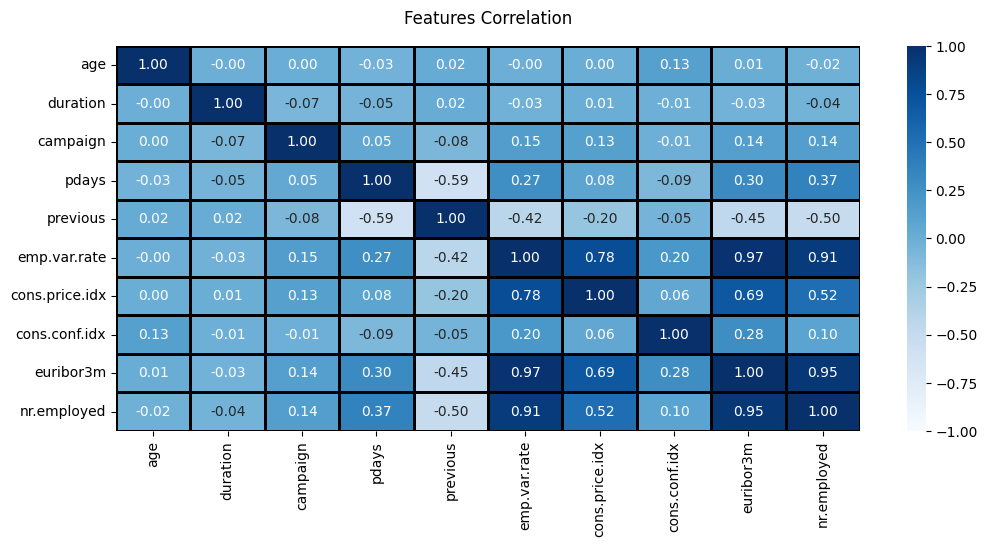

In [23]:
#plot
plt.figure(figsize=(12, 5))
heatmap = sns.heatmap(data.select_dtypes(include='number').corr(), vmin=-1, vmax=1, annot=True, 
                      cmap='Blues',fmt='.2f',linewidths=1,linecolor='black')
heatmap.set_title('Features Correlation', fontdict={'fontsize':12}, pad=16)
plt.show()

`From the heatmap above, it can be seen than euribor3m is strongly correlated with emp.var rate(0.97% correlation), nr.employed(91%). Also, nr.employed is strongly correlated with emp.var rate. since the main goal of this project is prediction and not model interpretability, we need not worry about multicollinearity affecting predictive power of our model.` 

#### Modelling

``` The duration variable was dropped because according to the data source,  "this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model".```

`Evaluation metric: The chosen evaluation metric is recall, which focuses on minimizing false negatives to capture as many potential subscribers as possible. This approach aims to reduce the risk of missed opportunities and maximize the bank's ability to identify customers likely to subscribe to the term deposit. However, the choice of evaluation metric ultimately depends on the specific business goal. It is crucial to strike a reasonable balance between recall and precision.`


In [24]:
#copy data to use for modelling
model_data=data.copy() 

#separate features from target
X=model_data.drop(columns=['subscription','duration'],axis=1) 
y=model_data['subscription'] 

#label encoding
le=LabelEncoder()
y=le.fit_transform(y)

In [25]:
#separate features based on datatypes
numeric_features=[]
categorical_features=[]
for col in X.columns:
    if (col in X.select_dtypes(include='number')):
        numeric_features.append(col)
    else:
        categorical_features.append(col)

In [26]:
rs=44 #random state

#split data into train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=rs)
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (32940, 19)
X_test shape: (8236, 19)


In [27]:
#construct column transformer for both datatypes of X
num_pipeline=make_pipeline(StandardScaler())
cat_pipeline=make_pipeline(OneHotEncoder(handle_unknown='ignore'))
# make columnTransformer
preprocessor = ColumnTransformer(transformers=[("num", num_pipeline, numeric_features),
                                               ("cat", cat_pipeline, categorical_features)])



In [28]:
#oversampling/undersampling
rus=RandomUnderSampler(random_state=rs)
ros=RandomOverSampler(random_state=rs)

In [29]:
#make custom scoring function
multi_scoring_function = {'accuracy':make_scorer(accuracy_score),
          '2nd_class_precision_score': make_scorer(precision_score,average='binary',pos_label=1),
          '2nd_class_recall_score': make_scorer(recall_score,average='binary',pos_label=1)}

In [30]:
#evaluate models with default values without addressing imbalance
model_details={}
model_names=['LogisticRegression','RandomForest','LightGBM']
models=[LogisticRegression(max_iter=1000,random_state=rs),RandomForestClassifier( n_jobs=-1,random_state=rs),
        LGBMClassifier(n_jobs=-1,verbose=-1,random_state=rs)]


for name,model in zip(model_names,models):
  model=imblearn_make_pipeline(preprocessor,model)
  model.fit(X_train,y_train)
  train_score=model.score(X_train, y_train)
  val_result=cross_validate(model,X_train,y_train,cv=5,scoring=multi_scoring_function)
  val_accuracy=val_result['test_accuracy'].mean()
  val_2nd_class_precision_score=val_result['test_2nd_class_precision_score'].mean()
  val_2nd_class_recall_score=val_result['test_2nd_class_recall_score'].mean()
  model_details[name]={'train_score':train_score,'val_accuracy':val_accuracy,
                      'val_2nd_class_precision_score':val_2nd_class_precision_score,
                      'val_2nd_class_recall_score':val_2nd_class_recall_score}

#dataframe
default_models_df=pd.DataFrame(model_details).T
default_models_df

,train_score,val_accuracy,val_2nd_class_precision_score,val_2nd_class_recall_score
LogisticRegression,0.900880,0.900091,0.666021,0.227707
RandomForest,0.994627,0.892350,0.542043,0.291024
LightGBM,0.914329,0.900577,0.642937,0.265430


`From the dataframe above, it is apparent that our model has a very low recall value for the positive (minority) class, which represents bank term deposit subscribers. This implies that the model is failing to accurately identify and capture a significant number of individuals who are likely to subscribe to the term deposit`

In [31]:
#applying class reweighing and random undersampling

#models to evaluate
model_details={}
model_names=['LogisticRegression','RandomForest','LightGBM']
models=[LogisticRegression(max_iter=1000,random_state=rs,class_weight={0:0.4,1:0.6}),
        RandomForestClassifier( n_jobs=-1,random_state=rs,class_weight={0:0.4,1:0.6}),
        LGBMClassifier(n_jobs=-1,verbose=-1,random_state=rs,class_weight={0:0.4,1:0.6})]


for name,model in zip(model_names,models):
  model=imblearn_make_pipeline(preprocessor,rus,model)
  model.fit(X_train,y_train)
  train_score=model.score(X_train, y_train)
  val_result=cross_validate(model,X_train,y_train,cv=5,scoring=multi_scoring_function)
  val_accuracy=val_result['test_accuracy'].mean()
  val_2nd_class_precision_score=val_result['test_2nd_class_precision_score'].mean()
  val_2nd_class_recall_score=val_result['test_2nd_class_recall_score'].mean()
  model_details[name]={'train_score':train_score,'val_accuracy':val_accuracy,
                      'val_2nd_class_precision_score':val_2nd_class_precision_score,
                      'val_2nd_class_recall_score':val_2nd_class_recall_score}
#dataframe
resampled_models_df=pd.DataFrame(model_details).T
resampled_models_df

,train_score,val_accuracy,val_2nd_class_precision_score,val_2nd_class_recall_score
LogisticRegression,0.734457,0.730935,0.253103,0.710051
RandomForest,0.834851,0.776988,0.286994,0.659122
LightGBM,0.769702,0.721767,0.248753,0.726218


`After trying various methods to address the imbalance, adjusting class weight(class reweighting) together with using random undersampling tecnique led to highest increase in recall value of the positive(minority) class. The value increases from about 27% to about 73%, which means that our model is now able to correctly identify potential customers about 73% of the time.`

#### Final Model after hyperparameter tunning

`hyperparameter tunning was done with optuna, and we got just a slight increase in recall, the best hyperparameters are used.`

In [32]:
#final model
final_lgbm=LGBMClassifier(n_jobs=-1,verbose=-1,random_state=rs,class_weight={0:0.4,1:0.6}, n_estimators= 421, max_depth= 16, 
                     learning_rate= 0.9103669836149376, subsample=0.6919498571754856, colsample_bytree= 0.8737560492190305,
                     reg_alpha= 1.9589492800297248, reg_lambda= 6.012285238177178)
final_model=imblearn_make_pipeline(preprocessor,rus, final_lgbm)

#### Evaluation of final model on test set

Test accuracy - 0.7037
Roc_auc score - 0.7145
Precision of second class is: 0.2360
Recall of second class is: 0.7284
Fscore of second clas is : 0.6027




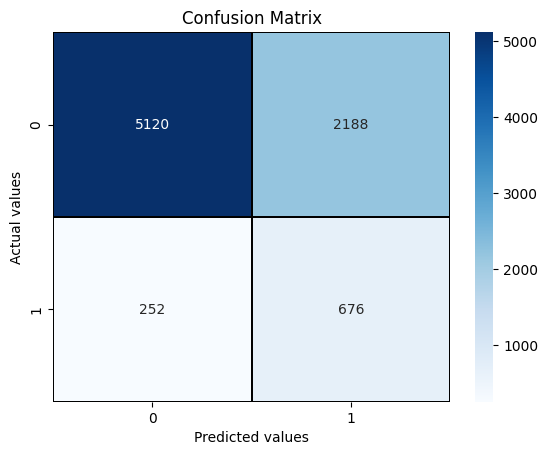

In [33]:
final_model.fit(X_train,y_train)
final_model_pred= final_model.predict(X_test)
print('Test accuracy -',round(accuracy_score(y_test,final_model_pred),4))
print('Roc_auc score -', round(roc_auc_score(y_test,final_model_pred),4))
precision, recall, f_beta, support = precision_recall_fscore_support(y_test,
                                        final_model_pred, beta=3, pos_label=1, average='binary')
print(f"Precision of second class is: {precision:.4f}")
print(f"Recall of second class is: {recall:.4f}")
print(f"Fscore of second clas is : {f_beta:.4f}")
print('\n')

#confusion matrix
cm=confusion_matrix(y_test,final_model_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',linewidth=0.3,linecolor='black')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')
plt.show()

`After evaluating model on test set, the final recall value of the minority class is approximately 73%.`

#### USING DURATION FOR BENCHMARK
---



In [34]:
#copy data to use for modelling
duration_data=data.copy() 
#separate features from target
X=duration_data.drop(columns=['subscription'],axis=1) 
y=duration_data['subscription'] 
#label encoding
le=LabelEncoder()
y=le.fit_transform(y)

#separate features based on datatypes
numeric_features=[]
categorical_features=[]
for col in X.columns:
    if (col in X.select_dtypes(include='number')):
        numeric_features.append(col)
    else:
        categorical_features.append(col)

rs=44 #random state

#split data into train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=rs)

#construct column transformer for both datatypes of X
duration_num_pipeline=make_pipeline(StandardScaler())
duration_cat_pipeline=make_pipeline(OneHotEncoder(handle_unknown='ignore'))
# make columnTransformer
preprocessor = ColumnTransformer(transformers=[("num", duration_num_pipeline, numeric_features),
                                               ("cat", duration_cat_pipeline, categorical_features)])



#applying class reweighing and randomundersampling
#models to evaluate
model_details={}
model_names=['LogisticRegression','RandomForest','LightGBM']
models=[LogisticRegression(max_iter=1000,random_state=rs,class_weight={0:0.4,1:0.6}),
        RandomForestClassifier( n_jobs=-1,random_state=rs,class_weight={0:0.4,1:0.6}),
        LGBMClassifier(n_jobs=-1,verbose=-1,random_state=rs,class_weight={0:0.4,1:0.6})]


for name,model in zip(model_names,models):
  model=imblearn_make_pipeline(preprocessor,rus,model)
  model.fit(X_train,y_train)
  train_score=model.score(X_train, y_train)
  val_result=cross_validate(model,X_train,y_train,cv=5,scoring=multi_scoring_function)
  val_accuracy=val_result['test_accuracy'].mean()
  val_2nd_class_precision_score=val_result['test_2nd_class_precision_score'].mean()
  val_2nd_class_recall_score=val_result['test_2nd_class_recall_score'].mean()
  model_details[name]={'train_score':train_score,'val_accuracy':val_accuracy,
                      'val_2nd_class_precision_score':val_2nd_class_precision_score,
                      'val_2nd_class_recall_score':val_2nd_class_recall_score}
#dataframe
resampled_models_df=pd.DataFrame(model_details).T
resampled_models_df

,train_score,val_accuracy,val_2nd_class_precision_score,val_2nd_class_recall_score
LogisticRegression,0.835610,0.835580,0.400136,0.920232
RandomForest,0.873376,0.851032,0.425410,0.917273
LightGBM,0.847905,0.845811,0.418371,0.943682


`From the dataframe above, it can been seen that with the inclusion of the duration column, we get high values on 5-fold cross validation, with recall of the minority class reaching up to 94% even without hyperparameter tuning.However, according to the data source, the duration varaiable should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.`